In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from dataclasses import dataclass, field
from sparrow import Protein
import re

2024-08-11 13:58:41.664621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 13:58:41.848924: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-11 13:58:41.898453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-11 13:58:41.898461: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart d

## Input staging function Declarations

### Tripeptide Column Generation

In [2]:
def getTripeptideColumn(df, ordered_list, disordered_list):
    '''
    Input: Dataframe containing the Columns: ID with PDB IDs, Residue Number containing position in the peptide,
           amino_acid containing the AA at that position and Disordered containing a binary value 

           List of Ordered statistically significant tripeptide motifs

           List of Disordered statistically significant tripeptide motifs

    Output: Input dataframe with a tripeptide significance column appended containing an array with binary values
            indicating whether all possible tripeptides containing that positions amino acid statistical significance

    Function: This function runs along every amino acid in a peptide and checks all tripeptides that contain it for 
              statistical significance against the lists provided 
    '''
    Significance_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
            tripeptides = list()
            if uniprot_df.loc[i, 'Disordered'] == 1:
                tripeptide_list = disordered_list

            elif uniprot_df.loc[i, 'Disordered'] == 0:
                tripeptide_list = ordered_list

            else:
                tripeptide_list = ordered_list
    # First Amino Acid
            if i == uniprot_df.index[0]:
                    """
                    [A]-T-C-Y-K-P-Y-L
                         0  1 2 3 4 5 6 7
                    
                    Should only return ATC
                    
                    """
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,1]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,0]

    # Second Amino Acid
            elif i == uniprot_df.index[1]:
                    """ 
                    A-[T]-C-Y-K-P-Y-L
                         0  1  2 3 4 5 6 7
                    
                    Should only return ATC and TCY
                    
                    """
                    
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,1]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0]
                    
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)

    # Last Amino Acid
            elif i == uniprot_df.index[-1]:
                    
                    """  A-T-C-Y-K-P-Y-[L]
                         0 1 2 3 4-3-2 -1
                         
                    Should only return PYL
                    
                    """
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [1,0,0]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,0]

    # Second Last Amino Acid
            elif i == uniprot_df.index[-2]:
                    
                    """  A-T-C-Y-K-P-[Y]-L
                         0 1 2 3 4-3 -2 -1
                         
                    Should only return PYL and KPY
                    
                    """
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [1]

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [0]
                    
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                            

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
    # All Other AAs
            else: 
                    
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [1]

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [0]
                        
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                        
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at position {i} in {uniprot_df.loc[i, 'ID']}\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
        
        Significance_df = pd.concat([Significance_df ,uniprot_df], ignore_index=True)

    return(Significance_df)
                        

### Amino Acid Vector Generation

In [3]:
def getAA_column(df):
    '''
    Input: Dataframe containing the Columns: ID with PDB IDs, Residue Number containing position in the peptide,
           amino_acid containing the AA at that position 

    Output: Input Dataframe with column containing a vector representing that rows amino acid in one hot encoding

    Function: Take all rows amino acid a generate a vector representing that amino acid in one hot encoding 
    '''

    vectorised_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
    # Positively Charged AAs
    # Arginine - Pos 1
            if uniprot_df.loc[i, 'amino_acid'] == 'R':
                i_list = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Histidine - Pos 2
            elif uniprot_df.loc[i, 'amino_acid'] == 'H':
                i_list = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector
                
    # Lysine - Pos 3
            elif uniprot_df.loc[i, 'amino_acid'] == 'K':
                i_list = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Negatively Charged AAs
    # Aspartic Acid - Pos 4
            elif uniprot_df.loc[i, 'amino_acid'] == 'D':
                i_list = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Glutamic Acid - Pos 5
            elif uniprot_df.loc[i, 'amino_acid'] == 'E':
                i_list = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Polar Uncharged AAs
    # Serine - Pos 6
            elif uniprot_df.loc[i, 'amino_acid'] == 'S':
                i_list = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Threonine - Pos 7 
            elif uniprot_df.loc[i, 'amino_acid'] == 'T':
                i_list = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Asparagine  - Pos 8 
            elif uniprot_df.loc[i, 'amino_acid'] == 'N':
                i_list = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Glutamine - Pos 9 
            elif uniprot_df.loc[i, 'amino_acid'] == 'Q':
                i_list = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Special cases - come back to this
    # Glycine - Pos 10
            elif uniprot_df.loc[i, 'amino_acid'] == 'G':
                i_list = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Proline - Pos 11
            elif uniprot_df.loc[i, 'amino_acid'] == 'P':
                i_list = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Cysteine - Pos 12
            elif uniprot_df.loc[i, 'amino_acid'] == 'C':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Hydrophobic AAs
    # Alanine - Pos 13
            elif uniprot_df.loc[i, 'amino_acid'] == 'A':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Valine - Pos 14
            elif uniprot_df.loc[i, 'amino_acid'] == 'V':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Isoleucine - Pos 15
            elif uniprot_df.loc[i, 'amino_acid'] == 'I':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Leucine - Pos 16
            elif uniprot_df.loc[i, 'amino_acid'] == 'L':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Methionine - Pos 17
            elif uniprot_df.loc[i, 'amino_acid'] == 'M':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Phenylalanine - Pos 18
            elif uniprot_df.loc[i, 'amino_acid'] == 'F':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector
        
    # Tyrosine - Pos 19
            elif uniprot_df.loc[i, 'amino_acid'] == 'Y':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Tryptophan - Pos 20
            elif uniprot_df.loc[i, 'amino_acid'] == 'W':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Empty Position - Pos Null
            elif uniprot_df.loc[i, 'amino_acid'] == '-':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector


            else:
                print("Mahoraga HELP ME")

        vectorised_df = pd.concat([vectorised_df ,uniprot_df], ignore_index=True)
    return vectorised_df

### Generate Ground truth binding binary value

In [4]:
def getGT_column(df):
    '''
    Input: Dataframe containing the Columns: ID with PDB IDs, Residue Number containing position in the peptide
           and a column containing a givens rows amino acids distance to RNA

    Output: Input dataframe with column appended containing binary binding value

    Function: Take the distance to RNA column and generate a binding binary vector based on whether its below 
              the threshold of 4.2
    '''
    GT_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
            if uniprot_df.loc[i, 'Distance_to_RNA'] > 4.2:
                uniprot_df.at[i, 'binding_ground_truth'] = [0]

            elif uniprot_df.loc[i, 'Distance_to_RNA'] <= 4.2:
                uniprot_df.at[i, 'binding_ground_truth'] = [1]

            else:
                sys.stderr.write(f"Non-Integer Input within Distance_to_RNA column")

        GT_df = pd.concat([GT_df, uniprot_df], ignore_index=True)

    return GT_df
            

### Disorder Prediction using Albatross and Sparrow Package

In [5]:
def getDisorder_column(df):
    '''

    '''
    Diso_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values

        uniprot_seq = uniprot_df['amino_acid'].str.cat()
        uniprot_prediction = Protein(uniprot_seq)
        uniprot_df = uniprot_df.reset_index()
        for i in uniprot_df.index:
            # currently using binary predict with the threshhold at 0.6
            # tighten this later but works for now - close enough to uniprot id features on selected AAs
            uniprot_df.at[i, 'Disordered'] =  uniprot_prediction.predictor.binary_disorder(recompute=True, disorder_threshold=0.6)[i]

        Diso_df = pd.concat([Diso_df, uniprot_df], ignore_index=True)

    return Diso_df
            

### Dataframe expansion for Model Input

In [6]:
def pretrain_expand(df):
    # Assuming 'amino_acid_vector' needs to be expanded
    amino_acid_df = pd.DataFrame(df['amino_acid_vector'].tolist(), index=df.index)
    amino_acid_df.columns = [f'amino_acid_{i}' for i in range(1,len(amino_acid_df.columns)+1)]  # Optional: Naming columns

    tripeptide_df = pd.DataFrame(df['tripeptide_significance'].tolist(), index=df.index)
    tripeptide_df.columns = [f'tri_peptide_aa_{i}' for i in range(1,len(tripeptide_df.columns)+1)]  # Optional: Naming columns

    # Now join this back to the original dataframe if necessary
    df_expanded = df.join(amino_acid_df)
    df_expanded = df_expanded.join(tripeptide_df)
    df_expanded.drop(columns=['amino_acid_vector','tripeptide_significance'], axis=1, inplace=True)

    return df_expanded

### Generate Dataframe for Model training

In [7]:
def training_data_preprocess(df, ordered_list, disordered_list, do_GT):


    if 'Disordered' in df.columns:
        pass

    else:
        df['Disordered'] = pd.NA
    if do_GT == True:
        req_columns = ["No", "ID", 'pdb_id', 'residue_number', 'amino_acid', 'Distance_to_RNA']

    elif do_GT == False:
        req_columns = ["No", "ID", 'residue_number', 'amino_acid', 'Disordered', 'RNA_binding']

    tripeptide_ready_data = df[req_columns]
    tripeptide_ready_data['tripeptide_significance'] = pd.NA
    tripeptide_ready_data['amino_acid_vector'] = pd.NA
    if do_GT == True:
        tripeptide_ready_data['RNA_binding'] = pd.NA

    if do_GT == True:
        tripeptide_ready_data['Disordered'] = pd.NA
        tripeptide_ready_data = getDisorder_column(tripeptide_ready_data)

    if do_GT == False:
        tripeptide_ready_data['binding_ground_truth'] = tripeptide_ready_data['RNA_binding']
        tripeptide_ready_data.drop(columns=['RNA_binding'], axis=1, inplace=True)
        
    post_tripeptide_df = getTripeptideColumn(tripeptide_ready_data, ordered_list, disordered_list)

    aa_vectorised_df = getAA_column(post_tripeptide_df)

    if do_GT == True:
        finalised_gt_df = getGT_column(aa_vectorised_df)

    if do_GT == False:
        finalised_gt_df = aa_vectorised_df

    resorted_finalsed_df = finalised_gt_df.sort_values(by='No', ascending = True)

    final_columns = ['ID','amino_acid_vector', 'tripeptide_significance', 'Disordered', 'binding_ground_truth']
    
    preExpand_df = resorted_finalsed_df[final_columns]

    model_input_final = pretrain_expand(preExpand_df)

    return model_input_final

### Input Vector Staging

In [8]:
training_data = pd.read_csv('All_combined_results.txt', sep='\t')

In [9]:
top20_tripep_ordered = pd.read_csv('Top20_tripeptides_ordered.csv')
top20_tripep_disordered = pd.read_csv('Top20_tripeptides_disordered.csv')

top20_tripep_ordered.rename(columns={'0': 'tripeptides'}, inplace= True)
top20_tripep_disordered.rename(columns={'0': 'tripeptides'}, inplace= True)

diso_significant_tripeptides = top20_tripep_disordered['tripeptides'].values
diso_significant_tripeptides = diso_significant_tripeptides.tolist()

ordered_significant_tripeptides = top20_tripep_ordered['tripeptides'].values
ordered_significant_tripeptides = ordered_significant_tripeptides.tolist()


In [31]:
completed_input_df = training_data_preprocess(training_data, ordered_significant_tripeptides, diso_significant_tripeptides, True)

/tmp/ipykernel_96540/2509891650.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripeptide_ready_data['tripeptide_significance'] = pd.NA
/tmp/ipykernel_96540/2509891650.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripeptide_ready_data['amino_acid_vector'] = pd.NA
/tmp/ipykernel_96540/2509891650.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

/tmp/ipykernel_96540/326207064.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniprot_df.at[i, 'binding_ground_truth'] = [1]
/tmp/ipykernel_96540/326207064.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniprot_df.at[i, 'binding_ground_truth'] = [0]
/tmp/ipykernel_96540/326207064.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

### Import of Disordered Test and Train Data

In [16]:
def read_in_diso_data(training_data_path):
    rows = []
    with open(training_data_path, 'r') as file:
        data = file.read()
        lines = data.strip().split('\n')
        for i in range(0, len(lines), 6):
            PDB_ID = lines[i].strip('>')
            Protein_Seq = lines[i+1]
            Disordered = lines[i+2]
            RNA_binding = lines[i+5]

            for i in range(len(Protein_Seq)):
                rows.append({'ID': PDB_ID, 'residue_number': i+1, 'amino_acid': Protein_Seq[i], 'Disordered': int(Disordered[i]), 'RNA_binding': int(RNA_binding[i])})

    staged_data_df = pd.DataFrame(rows)

    staged_data_df = staged_data_df[staged_data_df['Disordered'] != 0]

    staged_data_df['No'] = range(len(staged_data_df))

    staged_data_df = staged_data_df.reset_index()

    return staged_data_df

In [17]:
diso_training_data_df = read_in_diso_data('Diso_TrainingDataset.txt')

In [18]:
diso_training_input_df = training_data_preprocess(diso_training_data_df, ordered_significant_tripeptides, diso_significant_tripeptides, False)

In [19]:
diso_test_data_df = read_in_diso_data('TestDataset.txt')

In [20]:
diso_test_input_df = training_data_preprocess(diso_test_data_df, ordered_significant_tripeptides, diso_significant_tripeptides, False)

In [27]:
concatenated_input_df = pd.concat([completed_input_df, diso_test_input_df, diso_training_input_df], ignore_index=True)

In [28]:
concatenated_input_df.to_csv('Completed_diso_training_data.txt', sep='\t')

In [19]:
concatenated_input_df = pd.read_csv('Completed_diso_training_data.txt', sep='\t')

In [32]:
completed_input_df.to_csv('Diso_only_RBS.txt', sep='\t')

In [33]:
Diso_only_rbs_df = pd.read_csv('Diso_only_RBS.txt', sep='\t')

In [10]:
RBS_only_df = pd.read_csv('RBS_only_data.txt', sep='\t')

### Reshaping the data to make it compatible with a CNN:

In [21]:
# Assuming df_expanded is your final DataFrame after preprocessing
features = concatenated_input_df.drop(['binding_ground_truth', 'ID', 'Unnamed: 0'], axis=1)  # ID is also not a feature
labels = concatenated_input_df['binding_ground_truth']

# Convert DataFrame to numpy arrays
X = features.values
y = labels.values

# Reshape X to fit the CNN input shape (batch_size, height, width, channels)
# For 1D sequence data, you could treat each feature as a channel:
X = X.reshape((X.shape[0], 1, X.shape[1], 1))  # Height = 1, Width = number of features, Channels = 1

### Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Diso Train Time!!!

In [23]:
diso_model = Sequential([
    Conv2D(32, (1, 3), activation='relu', input_shape=(1, X_train.shape[2], 1)),  # Adjust the input shape and kernel
    MaxPooling2D(pool_size=(1, 2)),
    Flatten(),  # Flatten converts the 3D output to 1D for input to the fully connected layers
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

diso_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now, let's check the model summary to understand its architecture
diso_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 1, 22, 32)         128       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 11, 32)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 352)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                22592     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,785
Trainable params: 22,785
Non-trainable params: 0
__________________________________________________

In [24]:
history = diso_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
4000/4000 [==============================] - 6s 1ms/step - loss: 0.2673 - accuracy: 0.9203 - val_loss: 0.2650 - val_accuracy: 0.9213
Epoch 2/10
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2642 - accuracy: 0.9205 - val_loss: 0.2643 - val_accuracy: 0.9213
Epoch 3/10
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2639 - accuracy: 0.9205 - val_loss: 0.2630 - val_accuracy: 0.9213
Epoch 4/10
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2636 - accuracy: 0.9205 - val_loss: 0.2627 - val_accuracy: 0.9213
Epoch 5/10
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2631 - accuracy: 0.9205 - val_loss: 0.2637 - val_accuracy: 0.9213
Epoch 6/10
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2630 - accuracy: 0.9205 - val_loss: 0.2623 - val_accuracy: 0.9213
Epoch 7/10
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2627 - accuracy: 0.9205 - val_loss: 0.2620 - val_accuracy:

### Evalutation

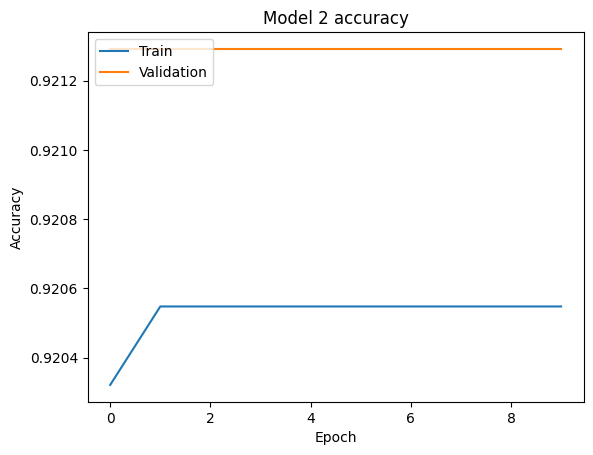

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])  # Ensure 'accuracy' is the right key; sometimes it could be 'acc'
plt.plot(history.history['val_accuracy'])  # Likewise, confirm if it should be 'val_accuracy' or 'val_acc'
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Model_02_Accuracy.png')
plt.show()

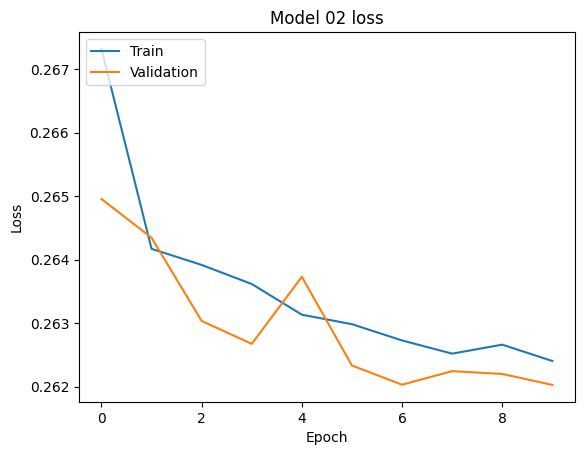

In [26]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('Model 02 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Model_02_Loss.png')
plt.show()

1714/1714 [==============================] - 1s 449us/step


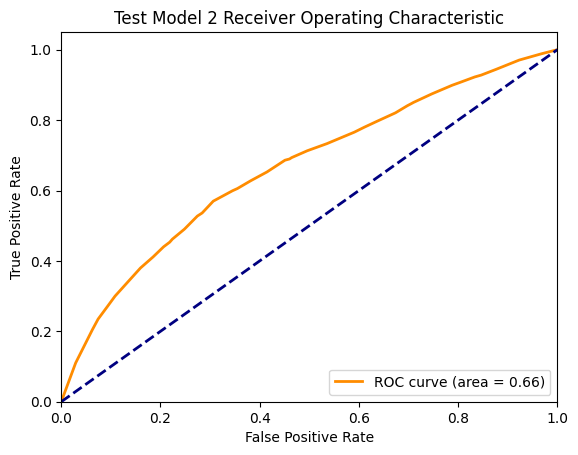

In [27]:
y_scores = diso_model.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Model 2 Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Model_02_ROC.png')
plt.show()


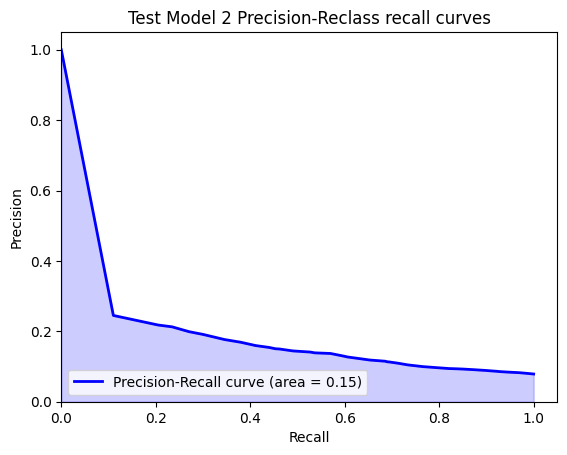

In [28]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Model 2 Precision-Reclass recall curves')
plt.legend(loc="lower left")
plt.savefig('Model_02_Recall.png')
plt.show()


### RBS only Model

In [34]:
Diso_only_rbs_df

,Unnamed: 0,ID,Disordered,binding_ground_truth,amino_acid_1,amino_acid_2,amino_acid_3,amino_acid_4,amino_acid_5,amino_acid_6,...,amino_acid_14,amino_acid_15,amino_acid_16,amino_acid_17,amino_acid_18,amino_acid_19,amino_acid_20,tri_peptide_aa_1,tri_peptide_aa_2,tri_peptide_aa_3
0,29181,P23396,0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,29182,P23396,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,29183,P23396,0,1.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,29184,P23396,0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29185,P23396,0,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97712,96947,Q9Y580,0,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97713,96948,Q9Y580,0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
97714,96949,Q9Y580,0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97715,96950,Q9Y580,0,1.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [35]:
# Assuming df_expanded is your final DataFrame after preprocessing
RBS_features = Diso_only_rbs_df.drop(['binding_ground_truth', 'ID', 'Unnamed: 0'], axis=1)  # ID is also not a feature
RBS_labels = Diso_only_rbs_df['binding_ground_truth']

# Convert DataFrame to numpy arrays
RBS_X = RBS_features.values
RBS_y = RBS_labels.values

# Reshape X to fit the CNN input shape (batch_size, height, width, channels)
# For 1D sequence data, you could treat each feature as a channel:
RBS_X = RBS_X.reshape((RBS_X.shape[0], 1, RBS_X.shape[1], 1))  # Height = 1, Width = number of features, Channels = 1

In [36]:
RBS_X_train, RBS_X_test, RBS_y_train, RBS_y_test = train_test_split(RBS_X, RBS_y, test_size=0.3, random_state=42)

In [37]:
RBS_model = Sequential([
    Conv2D(32, (1, 3), activation='relu', input_shape=(1, RBS_X_train.shape[2], 1)),  # Adjust the input shape and kernel
    MaxPooling2D(pool_size=(1, 2)),
    Flatten(),  # Flatten converts the 3D output to 1D for input to the fully connected layers
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

RBS_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now, let's check the model summary to understand its architecture
RBS_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1, 22, 32)         128       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 11, 32)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 352)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                22592     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,785
Trainable params: 22,785
Non-trainable params: 0
__________________________________________________

In [38]:
RBS_history = RBS_model.fit(RBS_X_train, RBS_y_train, epochs=10, validation_data=(RBS_X_test, RBS_y_test), batch_size=32)

Epoch 1/10
2138/2138 [==============================] - 3s 1ms/step - loss: 0.3323 - accuracy: 0.8890 - val_loss: 0.3352 - val_accuracy: 0.8865
Epoch 2/10
2138/2138 [==============================] - 3s 1ms/step - loss: 0.3289 - accuracy: 0.8890 - val_loss: 0.3360 - val_accuracy: 0.8865
Epoch 3/10
2138/2138 [==============================] - 3s 1ms/step - loss: 0.3288 - accuracy: 0.8890 - val_loss: 0.3347 - val_accuracy: 0.8865
Epoch 4/10
2138/2138 [==============================] - 3s 1ms/step - loss: 0.3287 - accuracy: 0.8890 - val_loss: 0.3349 - val_accuracy: 0.8865
Epoch 5/10
2138/2138 [==============================] - 3s 1ms/step - loss: 0.3286 - accuracy: 0.8890 - val_loss: 0.3345 - val_accuracy: 0.8865
Epoch 6/10
2138/2138 [==============================] - 3s 1ms/step - loss: 0.3283 - accuracy: 0.8890 - val_loss: 0.3343 - val_accuracy: 0.8865
Epoch 7/10
2138/2138 [==============================] - 3s 1ms/step - loss: 0.3283 - accuracy: 0.8890 - val_loss: 0.3363 - val_accuracy:

917/917 [==============================] - 0s 444us/step


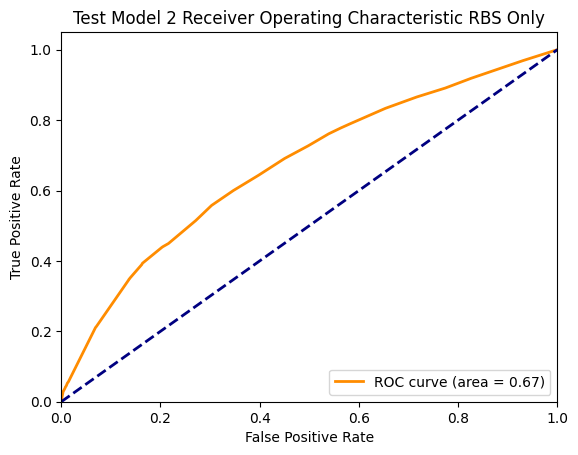

In [39]:
RBS_y_scores = RBS_model.predict(RBS_X_test)

fpr, tpr, _ = roc_curve(RBS_y_test, RBS_y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Model 2 Receiver Operating Characteristic RBS Only')
plt.legend(loc="lower right")
plt.savefig('Model_02_ROC_RBS.png')
plt.show()


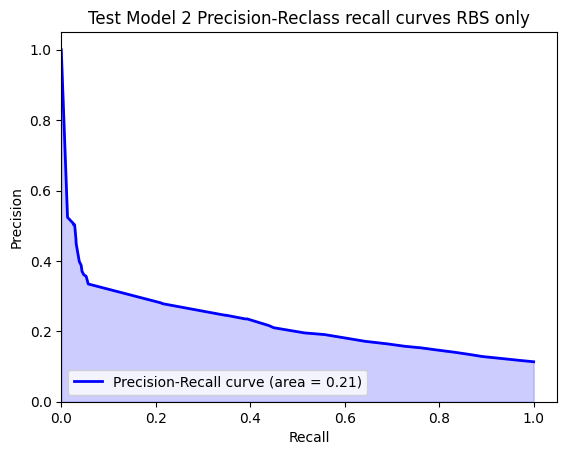

In [40]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(RBS_y_test, RBS_y_scores)
average_precision = average_precision_score(RBS_y_test, RBS_y_scores)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Model 2 Precision-Reclass recall curves RBS only')
plt.legend(loc="lower left")
plt.savefig('Model_02_Recall_RBS.png')
plt.show()
